# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

Start from Here as of October 9, 2021!

In [ ]:
# !pip install pyyaml==5.1
# # This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# # Install detectron2 that matches the above pytorch version
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

#!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# check pytorch installation:
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
ls -al /usr/local/cuda

lrwxrwxrwx 1 root root 22 Jun 21 00:40 /usr/local/cuda -> /etc/alternatives/cuda/


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
!rm -rf balloon/

from google.colab import drive
drive.mount('/content/drive')
#slumpsregion09aug.tar slumps_comaug.tar
!cp /content/drive/MyDrive/tmp/slumps_comaug.tar .

!tar -xf slumps_comaug.tar
!mv slumps_comaug balloon


Mounted at /content/drive


In [ ]:
# download, decompress the data

!rm -fr ./balloon/

!tar -xf slumps_com.tar
!mv slumps_com balloon


Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        # print(filename) #chunli
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        # print(annos.items()) #chunli
        for _, anno in annos.items():
            # print(anno) #chunli
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            #if key exist in the dictionary; Chunli
            key = 'category_id'
            if key in anno:
              category_id = anno["category_id"]
            else:
              category_id = 0

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["slump"]) #chunli
balloon_metadata = MetadataCatalog.get("balloon_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
dataset_dicts = get_balloon_dicts("balloon/train")
#balloon/train balloon/val  train
# dataset_dicts = get_balloon_dicts("slumps")
n=len(dataset_dicts)
for d in random.sample(dataset_dicts, 20):
# for i in range(1,n):
#     d=dataset_dicts[i]; #manually pick image

    #get number of polygons
    annotations=d["annotations"]; #
    print('The number of polygons is: ', len(annotations))

    if 1:
    # if len(annotations) > 1 :

      # d=dataset_dicts[1581-1-1552]; #manually pick image
      # d=dataset_dicts[(1581-1)*31-48112+11]; #manually pick image; val
      # d=dataset_dicts[(1655-1)*31-48112+0]; #manually pick image; val
      # d=dataset_dicts[(973-1)*1+0]; #manually pick image; train %(1522-1)*31+0

      img = cv2.imread(d["file_name"])
      # visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
      visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=1)
      out = visualizer.draw_dataset_dict(d)
      cv2_imshow(out.get_image()[:, :, ::-1])
      cv2_imshow(img[:, :, ::-1]) #No polygons

      print(d["file_name"])
      print(d)
print('\n Total number of files:',len(dataset_dicts))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Check GPU ;
# Standard GPUs are typically NVIDIA T4 Tensor Core GPUs,
# while premium GPUs are typically NVIDIA V100 or A100 Tensor Core GPUs.
# T4: 19 hours; A100-SXM: 2 hours;
!nvcc --version
!nvidia-smi
# tf.test.is_gpu_available()
# print(tf.test.is_gpu_available())

#You can see what GPU you've been assigned at any time by executing the following cell.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
# num_gpu = 1
# bs = (num_gpu * 2)
# cfg.SOLVER.BASE_LR = 0.02 * bs / 16  # pick a good LR; 0.0025
cfg.SOLVER.BASE_LR = 0.00025 # 0.002 #0.02 #0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 48000 #2000 ^ #48000 ^ #120000 #800 #8000 #800 #1400    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =512 #128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

print('Line 3 start train')
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print('line 4')
trainer = DefaultTrainer(cfg)
print('line 5')
trainer.resume_or_load(resume=True)
print('line 6')
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
#!kill 4068
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!zip output_case7aug.zip output/events* output/last_checkpoint output/metrics.json output/model_final.pth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp output_case7aug.zip /content/drive/MyDrive/tmp/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70 #0.99 #0.95 #0.9 #0.7 ^   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[10/13 02:50:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

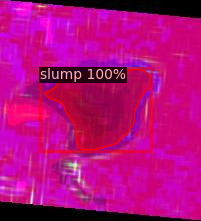

balloon/val/slump881rotation13.jpg classified


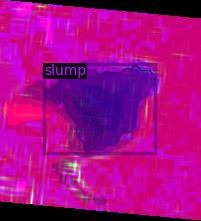

balloon/val/slump881rotation13.jpg ground truth


In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 1):
    # d=dataset_dicts[1581-1-1552]; #manually pick image
    # gully like curvature
    # balloon/val/slump1684.jpg slump1685.jpg slump1666

    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=1, #0.5
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    # add by Chunli
    import matplotlib.pyplot as plt
    print(d["file_name"], 'classified')

    # Original polygons
    visualizer = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    print(d["file_name"], 'ground truth')

    # print(im[1,1,0:3]) #chunli
    # plt.imshow(im[:,:,0]-im[:,:,1])
    # print('Difference max:',np.max((im[:,:,0]-im[:,:,1])))
    # mask1=outputs["instances"].pred_masks.cpu().numpy();
    # M2=mask1[0,:,:];
    # plt.imshow(M2)
    # print(outputs)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!cp /content/drive/MyDrive/tmp/slumpsub_region10.tar .

In [ ]:
!rm -rf ./slumppeelsub

!tar -xvf slumpsub_region10.tar
!rm slumpsub_region10.tar
!mv slumpsub_region10 slumppeelsub


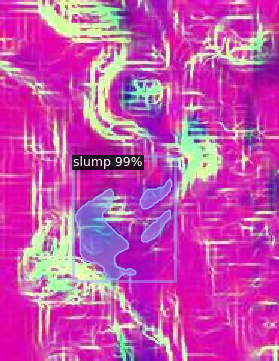

predicted


In [ ]:
import numpy, scipy.io

im = cv2.imread('slumppeelsub/slumppeelsubi130.jpg')#large gullies 6135 2103 4192 5526 4933 3807 5895 6641 29 1959 6689 1167

outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
if 1: #if plot images
  v = Visualizer(im[:, :, ::-1],
                metadata=balloon_metadata,
                scale=1.5, #0.5
                # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  print('predicted')
  # cv2_imshow(im[:, :, ::-1]) #No polygons



In [ ]:
# Retrieve slump masks for all the subtiles within a given region (50 km).

import os

lst = os.listdir("./slumppeelsub/") # your directory path
number_files = len(lst)
print('Total number of test images to work on: ',number_files)
n=number_files

import numpy, scipy.io

!rm -fr slumppeelsubmask
!mkdir slumppeelsubmask

for i in range(n):
#for i in [12]:
    namei='slumppeelsub/slumppeelsubi'+str(i+1)+'.jpg'
    if os.path.exists(namei) :
        placeholder=i;# print(namei)
    else :
        print(namei,' do no exist.')
        continue

    print(namei)
    im=cv2.imread(namei);
    #im = cv2.imread('balloon/val/slump13.jpg')
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    if 0: #if plot images
      v = Visualizer(im[:, :, ::-1],
                    metadata=balloon_metadata,
                    scale=5, #0.5
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
      )
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])
    #End of plotting

    classids=outputs["instances"].pred_classes.cpu().numpy();
    n_first=sum( classids==0 ); #the number of masks of the first class;
    mask1=outputs["instances"].pred_masks.cpu().numpy();
    n1=mask1.shape[0] #number of masks
    if (n1 >= 1 and n_first>=1):
      M2= numpy.zeros(mask1.shape[1:], dtype=bool); #initialize a false matrix
      for i in range(0,n1):  #i=0,1,2,3,...,n-1
        if classids[i]==0: #only save the first class
          M2=M2 | mask1[i,:,:];
      #plt.imshow(M2)  #merge all masks: if any mask gives 1, the pixel is 1.
      #store masks
      # ofile=namei.replace(".jpg", "mask.jpg")
      ofile=namei.replace("slumppeelsub", "slumppeelsubmask")
      ofile=ofile.replace(".jpg", ".mat")
      # ofile=ofile.replace(".tif", ".mat")
      scipy.io.savemat(ofile, mdict={'arr': M2})


In [ ]:

!mv slumppeelsubmask slump_case7aug_cand
!zip -r slump_case7aug_cand.zip slump_case7aug_cand/

# from google.colab import drive
# drive.mount('/content/drive')

!cp slump_case7aug_cand.zip /content/drive/MyDrive/tmp/



We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`